In [36]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

plt.ion()

In [52]:
dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Run_8_TBS_Experiment_ecr_results_windowed/'

In [53]:
dr1=dr+'230601 RUN 8 Wells 1-3'
dr2=dr+'230602 RUN 8 Wells 4-6'

In [54]:
filenames=os.listdir(dr1)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))

In [55]:
sorted_filenames_updated1=['230601 RUN 8 Wells 1-3/'+filename + '/data.raw_20240415_18h04m.pkl' for filename in sorted_filenames]

In [57]:
filenames=os.listdir(dr2)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))
sorted_filenames_updated2=['230602 RUN 8 Wells 4-6/'+filename + '/data.raw_20240415_18h04m.pkl' for filename in sorted_filenames]

In [58]:
sorted_filenames_updated=sorted_filenames_updated1+sorted_filenames_updated2

In [59]:
len(sorted_filenames_updated)

36

In [60]:
df = pd.read_csv('/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Time-file.csv')
df['time'] = pd.to_datetime(df['Unnamed: 1'].astype(str) + ' ' + df['Unnamed: 2'].astype(str), errors='coerce')

for i in df.loc[df['Unnamed: 2'].isnull(),'time'].index:
    df.loc[i,'time'] = df.loc[i-1,'time']+pd.Timedelta(10,'min')

well=4
stimulus_time=df[df[str(well)]==True]['time']
time=df[df['Unnamed: 2'].notna()]['time']
time_diff = [(t - time[0]).total_seconds() / 60 for t in time]
stimulus_time_diff = [(t - time[0]).total_seconds() / 60 for t in stimulus_time]

In [61]:
len(time_diff)

36

In [62]:
data_structure = np.column_stack((sorted_filenames_updated, time_diff))
#print(data_structure)
#float(data_structure[1,1])


In [63]:
all_win=[ 'win_0', 'win_1', 'win_2', 'win_3', 'win_4', 'win_5', 'win_6', 'win_7', 'win_8', 'win_9']


In [64]:
repeated_data = np.repeat(data_structure, 10, axis=0)
final_data = np.vstack((repeated_data[:, 0], repeated_data[:, 1])).T
window = np.array(all_win * len(time_diff)).reshape((-1, 1))
final_data = np.hstack((final_data, window))

In [65]:
for i in range(len(final_data)):
    win = final_data[i][2]
    value = float(final_data[i][1])
    if win == 'win_0':
        final_data[i][1] = str(value + 0)
    elif win == 'win_1':
        final_data[i][1] = str(value + 1)
    elif win == 'win_2':
        final_data[i][1] = str(value + 2)
    elif win == 'win_3':
        final_data[i][1] = str(value + 3)
    elif win == 'win_4':
        final_data[i][1] = str(value + 4)
    elif win == 'win_5':
        final_data[i][1] = str(value + 5)
    elif win == 'win_6':
        final_data[i][1] = str(value + 6)
    elif win == 'win_7':
        final_data[i][1] = str(value + 7)
    elif win == 'win_8':
        final_data[i][1] = str(value + 8)
    elif win == 'win_9':
        final_data[i][1] = str(value + 9)

final_data


array([['230601 RUN 8 Wells 1-3/#1 (baseline)/data.raw_20240415_18h04m.pkl',
        '0.0', 'win_0'],
       ['230601 RUN 8 Wells 1-3/#1 (baseline)/data.raw_20240415_18h04m.pkl',
        '1.0', 'win_1'],
       ['230601 RUN 8 Wells 1-3/#1 (baseline)/data.raw_20240415_18h04m.pkl',
        '2.0', 'win_2'],
       ...,
       ['230602 RUN 8 Wells 4-6/#18 (340 minutes after, Well #5 240 minutes after, Well #6 180 mintes after)/data.raw_20240415_18h04m.pkl',
        '1698.5', 'win_7'],
       ['230602 RUN 8 Wells 4-6/#18 (340 minutes after, Well #5 240 minutes after, Well #6 180 mintes after)/data.raw_20240415_18h04m.pkl',
        '1699.5', 'win_8'],
       ['230602 RUN 8 Wells 4-6/#18 (340 minutes after, Well #5 240 minutes after, Well #6 180 mintes after)/data.raw_20240415_18h04m.pkl',
        '1700.5', 'win_9']], dtype='<U136')

In [66]:
well='well004'

In [67]:
def filter_matrix_TC(data, well, win):

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well][win]['adj_matrix_predicted']
    votes = data[well][win]['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well][win]['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix

In [68]:
os.chdir(dr)


In [202]:
all_adj = []
k=-1
kk=[]
for i in range(len(sorted_filenames_updated)):
    with open(sorted_filenames_updated[i], 'rb') as f:
        data = pkl.load(f)
    for j in range(10):
        adj = filter_matrix_TC(data, well, all_win[j])
        all_adj.append(adj)
        k=k+1
        if(sum(sum(adj))>20000):
            kk.append(k)
            print(i,j,k, sum(sum(adj))>20000, adj.shape[0] )


0 0 0 True 978
3 0 30 True 979
5 0 50 True 980
6 0 60 True 982
7 0 70 True 982
8 2 82 True 987
11 0 110 True 975
12 2 122 True 982
13 3 133 True 975
14 1 141 True 981
15 0 150 True 971
18 3 183 True 951
19 1 191 True 954
19 4 194 True 954
20 0 200 True 955
21 0 210 True 948
22 1 221 True 952
23 2 232 True 948
24 1 241 True 950
25 2 252 True 951
28 0 280 True 949
29 2 292 True 943
30 4 304 True 949
31 3 313 True 945
32 1 321 True 954
34 0 340 True 952


In [85]:
m=len(kk)

In [86]:
## time points we selected that are dense enough 
final_data[kk,1]

array(['0.0', '39.68333333333333', '71.03333333333333',
       '84.26666666666667', '97.5', '112.75', '157.26666666666668',
       '172.48333333333332', '193.05', '221.31666666666666',
       '250.18333333333334', '1383.45', '1394.6666666666667',
       '1397.6666666666667', '1406.8833333333334', '1420.1166666666666',
       '1434.3666666666666', '1453.8', '1466.0833333333333',
       '1480.3666666666666', '1525.8666666666666', '1541.1', '1556.35',
       '1575.4833333333333', '1603.3333333333333', '1662.1166666666666'],
      dtype='<U136')

In [203]:
all_adj_new=[]
all_adj_new = [all_adj[i] for i in kk]

/Users/tianyichen/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


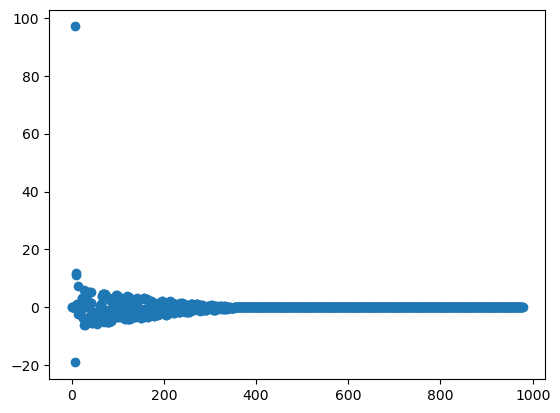

In [82]:
s,u=np.linalg.eig(all_adj_new[1])
plt.scatter(range(all_adj_new[1].shape[0]),s)

In [83]:
all_adj_new[1].shape

(979, 979)

In [204]:
## add zeros to the adj mat such that they have the same dims 
dim = 987 # Max number of vertices to determine dimension
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size
m=len(all_adj_new)
for i in range(m):
    ma = all_adj_new[i]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 

In [88]:
sum(adj_aug[0])

array([ 16., 111.,   0.,   0., 107., 158.,   0.,   0.,   0.,   7.,   0.,
         2.,   0.,   0.,   6.,   2.,   0.,  43.,   0.,   0.,   0., 142.,
         0.,   3.,   7.,  92.,   0.,  27.,   0.,   8.,  13.,   0.,   0.,
         0.,   0.,  72.,   3., 116.,   4.,   0.,  28.,   0.,  17.,   0.,
         0., 118.,   0.,  16.,   6.,   0., 124.,   4.,   0.,   0.,   0.,
       208.,  30.,   0.,   3.,  23.,   0.,   0.,   0.,   0.,  84.,  87.,
         0.,   0.,  88.,  64.,   0.,   0.,   0.,   0.,   0.,   0.,  26.,
        31.,   3.,   0.,  16.,   0.,   0.,   0., 147.,   0.,   0.,   0.,
         0.,   0.,   1.,   0.,   0.,   3.,  70.,  32.,   0.,   0.,   5.,
       117.,   0.,  34.,   0.,   0., 158.,  40.,  71.,  15.,   0.,  82.,
         0.,   0.,   0., 109.,   0.,   2.,   0.,   0.,   3.,   2.,   0.,
         0.,   0.,  60.,  16., 178.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 195.,   0.,  45.,  30., 132.,   0.,   0., 138.,   0., 102.,
        77., 132.,   0., 169.,   0.,   0.,   5.,   

In [143]:
from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline

In [144]:
count = len([x for x in kk if x < 180])
kk[count]

183

In [145]:
for i in range(0, count):
    adj_gm[i] = adj_aug[i]
    print(kk[i])

0
30
50
60
70
82
110
122
133
141
150


In [146]:
## only match between two days

res = quadratic_assignment(adj_aug[count-1],adj_aug[count],options = {'maximize': True})
perm = res['col_ind']
adj_gm[count] = adj_aug[count][perm][:,perm]

In [147]:
for i in range(count, m):
    adj_gm[i] = adj_aug[i][perm][:,perm]
    print(kk[i])

183
191
194
200
210
221
232
241
252
280
292
304
313
321
340


In [152]:
from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline
for i in range(1, m):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    print(f"Frob diff before GM: {before_norm}, After GM: {after_norm}")

Frob diff before GM: 202.0519735117675, After GM: 134.72564715005083
Frob diff before GM: 204.4309174268902, After GM: 141.8238343861849
Frob diff before GM: 219.79535936866364, After GM: 146.79918255903198
Frob diff before GM: 213.96027668705236, After GM: 142.01056298740596
Frob diff before GM: 204.1102643180886, After GM: 127.78497564267875
Frob diff before GM: 211.41192019372986, After GM: 148.50252523105456
Frob diff before GM: 228.93012034243114, After GM: 147.38046003456498
Frob diff before GM: 200.62651868584072, After GM: 130.83195328359201
Frob diff before GM: 217.1635328502463, After GM: 142.35870187663275
Frob diff before GM: 242.58606720090089, After GM: 154.30489298787643
Frob diff before GM: 241.07675126399062, After GM: 157.30225681788548
Frob diff before GM: 238.1134183535233, After GM: 157.0350279396288
Frob diff before GM: 229.02401620790778, After GM: 156.44807445283564
Frob diff before GM: 205.23401277566055, After GM: 136.46611300978716
Frob diff before GM: 218.51

In [209]:
## only consider the June 02 data and no matching
prod=adj_aug[11]
for i in (range(11,m,2)):
    prod=prod * adj_aug[i]
    print(i, sum(sum(prod)))
## find the connected component for the common edge subgraph 
[a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
len(ind)
n=len(ind)
n

11 27467.0
13 2013.0
15 573.0
17 117.0
19 84.0
21 58.0
23 33.0
25 27.0


12

In [ ]:
sampled_indices = [i for i in range(1, m, 2)]


In [201]:
## find largest common connected component 
prod=adj_gm[11]
for i in (range(11,m)):
    prod=prod * adj_gm[i]
    print(i, sum(sum(prod)))

11 27467.0
12 17019.0
13 10399.0
14 7180.0
15 5854.0
16 5129.0
17 3819.0
18 3408.0
19 2959.0
20 2692.0
21 2285.0
22 1768.0
23 1531.0
24 1345.0
25 1137.0


In [154]:
## find largest common connected component 
prod=adj_gm[0]
for i in (range(m)):
    prod=prod * adj_gm[i]
    print(i, sum(sum(prod)))

0 22919.0
1 12448.0
2 9539.0
3 7510.0
4 5693.0
5 4647.0
6 4062.0
7 3406.0
8 2895.0
9 2569.0
10 2301.0
11 1968.0
12 1744.0
13 1443.0
14 1201.0
15 1053.0
16 959.0
17 779.0
18 729.0
19 660.0
20 598.0
21 533.0
22 430.0
23 363.0
24 316.0
25 270.0


In [155]:
from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils

In [156]:
## find the connected component for the common edge subgraph 
[a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
len(ind)
n=len(ind)
n

86

In [157]:
# double check every adj mat is connected 
glist=np.zeros([m,len(ind),len(ind)])
for i in range(m):
    glist[i]=adj_gm[i][ind][:,ind]
    print(graspologic_utils.is_fully_connected(glist[i]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


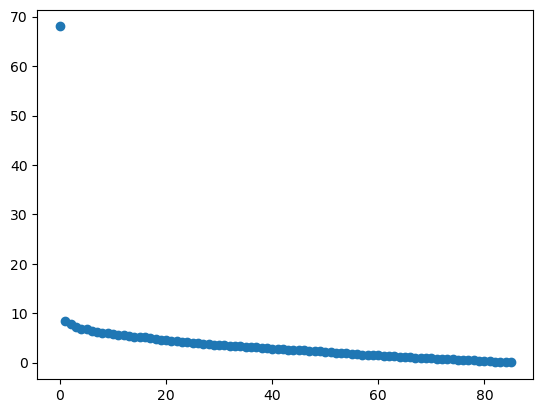

In [158]:
## scree plot for one graph 
u,s,v=np.linalg.svd(glist[0], full_matrices=True)
plt.scatter(range(n),s)

In [159]:
from graspologic.embed import AdjacencySpectralEmbed

In [161]:
tm=kk

In [162]:
ed=1
Xhat_list=np.zeros([len(tm),n,2*ed])
for i in range(len(tm)):
    ase = AdjacencySpectralEmbed(n_components=ed)
    Xhat, Yhat = ase.fit_transform(glist[i])
    Xhat_list[i][:,list(np.arange(ed))]=Xhat
    Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

In [163]:
from scipy.linalg import orthogonal_procrustes
D=np.zeros([len(tm),len(tm)])

In [164]:
for i in range(len(tm)):
    for j in range(len(tm)):
        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  

In [165]:
J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J

Text(0, 0.5, 'eigen value')

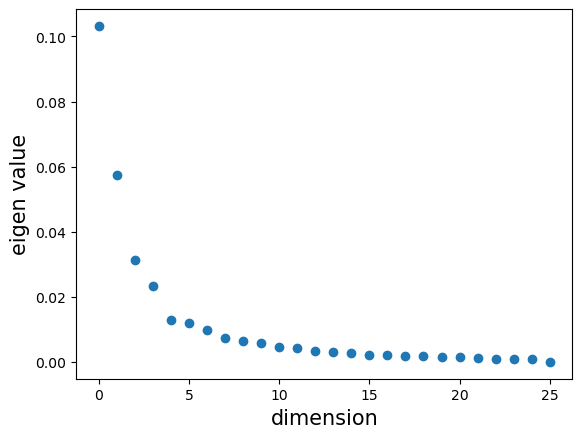

In [166]:
H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
plt.xlabel('dimension',fontsize=15)
plt.ylabel('eigen value',fontsize=15)

In [167]:
d=4
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))

281

Text(0, 0.5, 'dim 2')

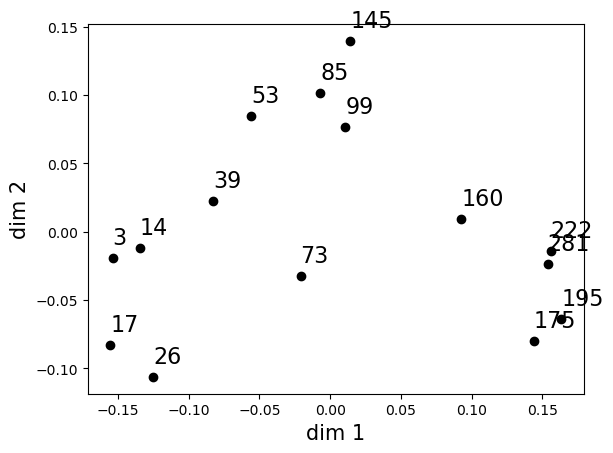

In [130]:
plt.scatter(MDS[:,0],MDS[:,1],color='black')
for i in range(len(tm)):
    plt.text(MDS[i,0],MDS[i,1]+0.01,int(float(final_data[kk[i],1])), fontsize=16)
plt.xlabel("dim 1",fontsize=15)
plt.ylabel("dim 2",fontsize=15)

In [168]:
from sklearn.manifold import Isomap

In [172]:
embedding = Isomap(n_neighbors=2,n_components=1)
iso = embedding.fit_transform(MDS)

In [105]:
%store -r time_diff

In [177]:
float(final_data[kk,1])


TypeError: only size-1 arrays can be converted to Python scalars

In [187]:
new_list = np.array(final_data[kk, 1]).astype(float).astype(int)
new_list


array([   0,   39,   71,   84,   97,  112,  157,  172,  193,  221,  250,
       1383, 1394, 1397, 1406, 1420, 1434, 1453, 1466, 1480, 1525, 1541,
       1556, 1575, 1603, 1662])

[1390.45, 1403.6666666666667, 1416.8833333333334, 1430.1166666666666]

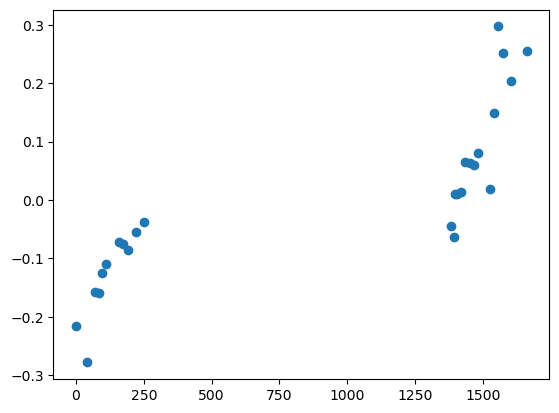

In [189]:

plt.scatter(new_list, iso)
stimulus_time_diff

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


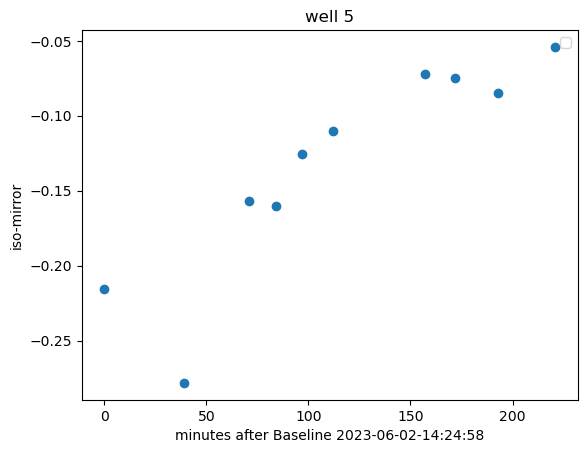

In [197]:

# Plot the scatter plot
plt.scatter(new_list[:10], iso[:10])

# Add vertical lines
#plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
#plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
#plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
#plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

# Set the x-axis label and y-axis label
plt.xlabel('minutes after Baseline 2023-06-02-14:24:58')
plt.ylabel('iso-mirror')

# Add a title
plt.title('well 5')

# Add a legend
plt.legend()

# Show the plot
plt.show()


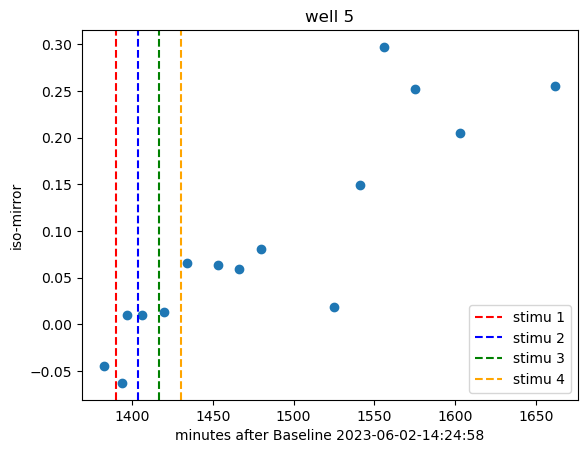

In [199]:
# Plot the scatter plot
plt.scatter(new_list[11:], iso[11:])

# Add vertical lines
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

# Set the x-axis label and y-axis label
plt.xlabel('minutes after Baseline 2023-06-02-14:24:58')
plt.ylabel('iso-mirror')

# Add a title
plt.title('well 5')

# Add a legend
plt.legend()

# Show the plot
plt.show()
